# Fast template matching

### Background

This notebook describes how the new accelerated orientation mapping facilities in Pyxem can be used.
Orientation mapping with template matching is illustrated in [example 02](https://github.com/pyxem/pyxem-demos/blob/master/02%20GaAs%20Nanowire%20-%20Phase%20Mapping%20-%20Orientation%20Mapping.ipynb) but that example concerns a small dataset with the orientations very close to zone axis, which doesn't require large template libraries.
In this implementation, the template library samples $SO(3)$ (all of Euler space) and subsequently compares all templates to the experimental patterns.
Sampling all of Euler space requires a very large template library, on the order of 300000, in order to ensure a maximum of about 2$^\circ$ between orientations.
In the general case where we don't have any information about the orientations, this requires both a long time to calculate the template library and to index the dataset.

The "fast" approach aims to mimic ideas in commercial template matching codes like ASTAR. 
The goal here is that real 4D-STEM datasets containing arbitrary orientations can be indexed in reasonable time.
To achieve this, template libraries are simulated by sampling $S^2$ (the surface of the sphere) instead, which represents all possible beam directions relative to the crystal.
The euler angle that represents the in-plane rotation is constrained to 0.
Removing one degree of freedom drastically limits the size of the library.
The in-plane rotation angle is found during the indexation process by matching the templates to the images in polar coordinates.
This is also a computationally demanding task but it can be substantially parallelized.
**If you have large 4D-STEM/NBED dataset of real samples with unknown orientations you should consider following this example**.

### Structure

1. <a href="#load">Load, inspect, calibrate data</a>
2. <a href="#pre">Preprocess images</a>
3. <a href="#sim">Build template library</a>
4. <a href="#index">Perform indexation</a>
    * <a href="#1p1t">One pattern, one template</a>
    * <a href="#1pmt">One pattern, many templates</a>
    * <a href="#mpmt">Many patterns, many templates</a>

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import zarr

# <a id="load"></a> 1. Load, inspect, calibrate data

In [3]:
# how to save using the zip store with zarr (good for sharing datasets with 1 file)
#filename = 'data/11/sample_with_g.zspy'
#store = zarr.ZipStore(path=filename)
#experimental_data.save(store,close_file=False)

In [4]:
filename = 'data/11/sample_with_g.zspy'
store = zarr.ZipStore(path=filename)
experimental_data = hs.load(store, lazy=True)

In [5]:
experimental_data

<LazyElectronDiffraction2D, title: , dimensions: (25, 26|256, 256)>

### Centering the dataset

In [6]:
experimental_data.center_direct_beam(method="blur", half_square_width=50, sigma=1.5)

### Affine transformation
There is some projector astigmatism in this dataset which must be corrected for prior to indexation. The entries of the affine transformation matrix were obtained through manual iteration to ensure that the spots that were recognized fit well.

In [7]:
# Define the affine transform matrices obtained from manual iteration to see what fits templates best
# An automated way to optimize the affine transformation matrix is under construction
matrix_transfo = np.array([[ 0.93356802, -0.04315628,  0.        ],
                           [-0.02749365,  0.96883687,  0.        ],
                           [ 0.        ,  0.        ,  1.        ]])

experimental_data = experimental_data.apply_affine_transformation(matrix_transfo, inplace=False)

### Scale calibration
To find out the pixel calibration of the images, we calibrate it based on the known distance of some diffraction spots.
In this case we draw a profile through the $\{220\}$ reflections of the austenite phase, of which we know the distance in reciprocal space.

In [8]:
experimental_data.set_diffraction_calibration(1)

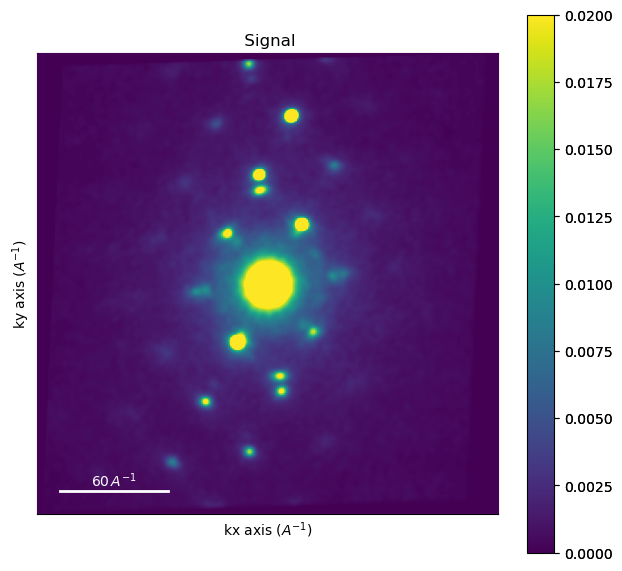

In [9]:
from hyperspy.roi import Line2DROI

# a line profile accross known diffraction spots
x1 = -7.47
x2 = 8.63
y1 = -74.63
y2 = 70.83
line = Line2DROI(x1=x1, y1=y1, x2=x2, y2=y2, linewidth=5)

image1 = experimental_data.inav[0, 0]
image1.plot(cmap="viridis", vmax=0.02)
plt.plot([x1, x2], [y1, y2], c = "red")

In [10]:
plt.close()

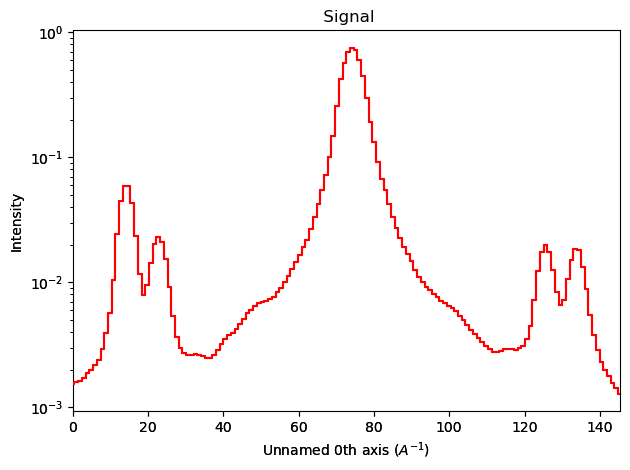

In [11]:
trace = line(image1).as_signal1D(0)
trace.plot(norm="log")

In [12]:
plt.close()

In [13]:
trace = np.log(trace)

In [14]:
import scipy.signal as sps
sps.find_peaks(trace.data)

(array([ 15,  23,  33,  75, 117, 127, 135]), {})

In [15]:
# the number of pixels center to 022 peak
dist_002_pixels = (135 - 15)/2
# the distance in 1/A of the 022 peak
g_dist = np.sqrt(8)/3.59
diffraction_calibration = g_dist/dist_002_pixels
print(diffraction_calibration)

0.0131310451473825


In [16]:
experimental_data.set_diffraction_calibration(diffraction_calibration)

# <a id="pre"></a> 2. Image processing
We apply some basic image filtering on the images to make the template matching result more "smooth".

In [17]:
from skimage import filters

# Set values lower than a specific value to 0 in the image
def crop_minimum(image, minimum=0.0005):
    copied = image.copy()
    copied[copied <= minimum] = 0.
    return copied

In [18]:
# difference of gaussians serves to remove the background intensity
procdat = experimental_data.subtract_diffraction_background(method="difference of gaussians",
                                                            min_sigma=3,
                                                            max_sigma=8, )
# smooth out the output
procdat = procdat.map(filters.gaussian, sigma=0.5, inplace=False)
# remove low intensities
procdat = procdat.map(crop_minimum, minimum = 0.0005, inplace=False)

In [19]:
# to get access to the functions of electron diffraction patterns
procdat.set_signal_type(signal_type="electron_diffraction")

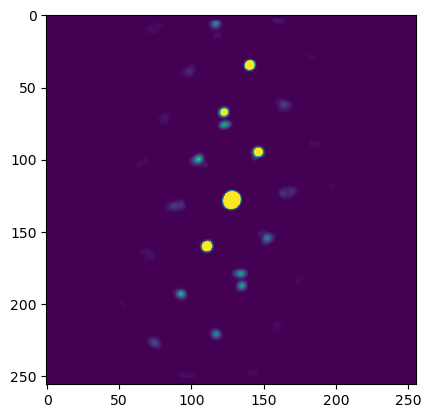

In [20]:
plt.imshow(procdat.inav[0,0].data, vmin=0, vmax=0.03)

In [21]:
plt.close()

In [22]:
experimental_data = procdat

# <a id="sim"></a> 3. Simulate template library

The `get_beam_directions_grid` function will sample $S^2$ to get the beam directions where we want to simulate patterns.

In the cell below, decrease `resolution` to increase the finesse of the grid. Note that the number of templates will increase in an approximately inverse squared way as this value is decreased.

In [23]:
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
resolution = 1.5 # maximum angle in degrees between nearest templates. Pretty rough grid for speed.
grid_cub = get_beam_directions_grid("cubic", resolution, mesh="spherified_cube_edge")
print("Number of patterns: ", grid_cub.shape[0])

Number of patterns:  496


/Users/carterfrancis/mambaforge/envs/pyxem-demos/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:514: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


(-0.1, 0.5)

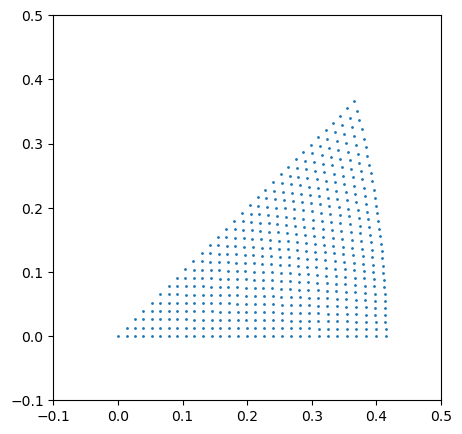

In [24]:
# this cell serves to visualize the grid of orientations in stereographic projection

# a helper function for turning the euler angle grid to a grid of points in the stereographic projection
def grid_to_xy(grid):
    from orix.quaternion.rotation import Rotation
    from orix.vector.vector3d import Vector3d
    from orix.projections import StereographicProjection
    s = StereographicProjection(pole=-1)
    rotations_regular =  Rotation.from_euler(np.deg2rad(grid))
    rot_reg_test = rotations_regular*Vector3d.zvector()
    x, y = s.vector2xy(rot_reg_test)
    return x, y

fig, ax1 = plt.subplots(1, figsize=(5, 5))
ax1.scatter(*grid_to_xy(grid_cub), s = 1)
ax1.set_xlim(-0.1, 0.5)
ax1.set_ylim(-0.1, 0.5)

In [25]:
plt.close()

Here we simulate the actual library using diffsims.

In [26]:
import diffpy
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator

In [27]:
# Parameters necessary for simulating a template library

# half size of the images
half_shape = (experimental_data.data.shape[-2]//2, experimental_data.data.shape[-1]//2)
# maximum radius in reciprocal space to calculate spot intensities for
reciprocal_radius = np.sqrt(half_shape[0]**2 + half_shape[1]**2)*diffraction_calibration

In [28]:
# importing the structure
structure_matrix = diffpy.structure.loadStructure("data/11/austeniteLP.cif")

# "The microscope = the parameters that determine how the templates are calculated"
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                precession_angle=0,
                                scattering_params=None,
                                shape_factor_model="linear",
                                minimum_intensity=0.1,
                                )

lib_gen = DiffractionLibraryGenerator(diff_gen)

# Generating a library
# "Library of structures and orientations"
library_phases_fe = StructureLibrary(["fe"], [structure_matrix], [grid_cub])
# Calculate the actual library

diff_lib_fe = lib_gen.get_diffraction_library(library_phases_fe,
                                           calibration=diffraction_calibration,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=half_shape,
                                           with_direct_beam=False,
                                           max_excitation_error=0.07)

# <a id="index"></a> 4. Index results
Here we illustrate how we can actually compare the templates to the experimental patterns

In [29]:
from pyxem.utils import indexation_utils as iutls
from pyxem.utils import plotting_utils as putls
from pyxem.utils import polar_transform_utils as ptutls
from pyxem.utils import expt_utils as eutls

### <a id="1p1t"></a> Single pattern and single template
If one has a single diffraction pattern and a single template, the goal is to find the in-plane angle, or the correlation at each in-plane angle.

Text(0, 0.5, 'Correlation')

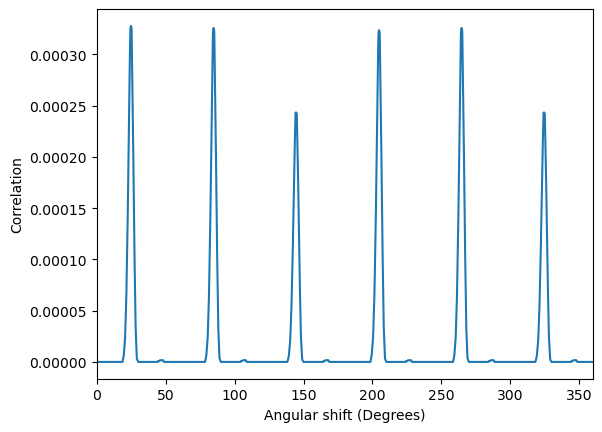

In [30]:
# pull out a random image and simulation
image = experimental_data.inav[0,0].data
simulation_test = diff_lib_fe["fe"]["simulations"][-1]

# for completeness in the illustration, all keyword arguments are given and explained
# an array of angles and corresponding correlation values are returned
a, c = iutls.get_in_plane_rotation_correlation(
    image,
    simulation_test,
    intensity_transform_function=None,  # a function applied both to the image and template intensities before calculating the correlation
    delta_r = 1,                        # sampling in the radial direction
    delta_theta = 0.1,                  # sampling in the azimuthal direction
    max_r = None,                       # maximum radius to consider, by default the distance from the center to the corner
    find_direct_beam = True,            # convenience, if the pattern was not centered, this will perform a rough centering
    direct_beam_position = None,        # manually provide the coordinates of the direct beam
    normalize_image=True,               # divide the correlation by the norm of the image
    normalize_template=True,            # divide the correlation by the norm of the template
)

fig, ax = plt.subplots()
ax.plot(a, c)
ax.set_xlim(0, 360)
ax.set_xlabel("Angular shift (Degrees)")
ax.set_ylabel("Correlation")

In [31]:
plt.close()

(<Axes: >,
 <matplotlib.collections.PathCollection at 0x16a2c8f90>)

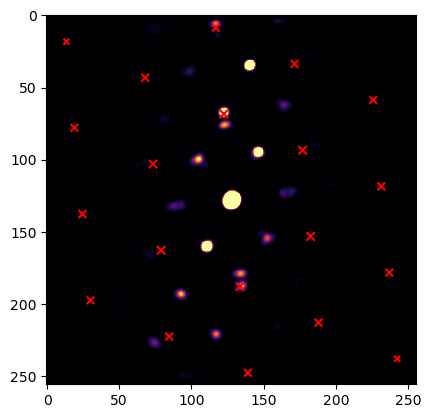

In [32]:
# again a convenience function implemented as sanity check
putls.plot_template_over_pattern(image,
                                 simulation_test,
                                 in_plane_angle=a[np.argmax(c)],
                                 coordinate_system = "cartesian", 
                                 size_factor = 10,
                                 vmax=0.02, 
                                 max_r = 200,
                                 find_direct_beam=True,
                                 cmap = "inferno"
                                )

In [33]:
plt.close()

### <a id="1pmt"></a> Single pattern, multiple templates
Sometimes one has a single pattern and wants to compare it to an entire template library.

In [34]:
simulations = diff_lib_fe["fe"]["simulations"]

# these arguments are the same as before, for convenience we define them here
delta_r = 1
delta_theta = 1 
max_r = None
intensity_transform_function = None
find_direct_beam = True
direct_beam_position = None
normalize_image = True
normalize_templates = True

In the following function we only calculate the match between a radially integrated image and radially integrated templates.
This is very fast but it is no longer possible to find out the in-plane angle of best fit, only a correlation value is returned for each template.

In [35]:
fast_cors = iutls.correlate_library_to_pattern_fast(
    image, simulations, delta_r, delta_theta, max_r, intensity_transform_function, find_direct_beam,
    direct_beam_position, normalize_image, normalize_templates,
)

To find out the (in-plane) angle of best fit, we must do a full correlation matching.
We can slightly speed up the calculation by only performing a full correlation on templates that have a good correlation index in the fast approach.
The `frac_keep` and `n_keep` parameters determine how many patterns are fully indexed.
They both do the same thing, but with the former the number of templates to retain is specified as a fractional value between (0, 1], and the latter is just an integer on the interval [1, N] with N the number of templates in the library.

In [36]:
frac_keep = 0.8 
n_keep = None

# if frac_keep < 1 or 1 < n_keep < number of templates then indexation will be performed on the
# templates in "indexes" that have the highest "fast" correlation
indexes, angles, corrs, angles_m, corrs_m = iutls.correlate_library_to_pattern(
    image, simulations, frac_keep, n_keep, delta_r, delta_theta, max_r,
    intensity_transform_function, find_direct_beam, direct_beam_position,
    normalize_image, normalize_templates,
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


What is returned are the indexes of retaines templates, the angles of best fit, the correlation of the templates, but also the angle of best fit for the mirrored template and the correlation for this mirrored template.
This is because sometimes you want to know how well the 180 degree ambiguity is resolved. Below we plot all these results on the stereographic axes.
You can see that if we reduce `frac_keep` or increase `n_keep` there are "holes" in the stereogram for bad matching templates that were not considered.

Text(0.5, 1.0, 'Mirrored angles')

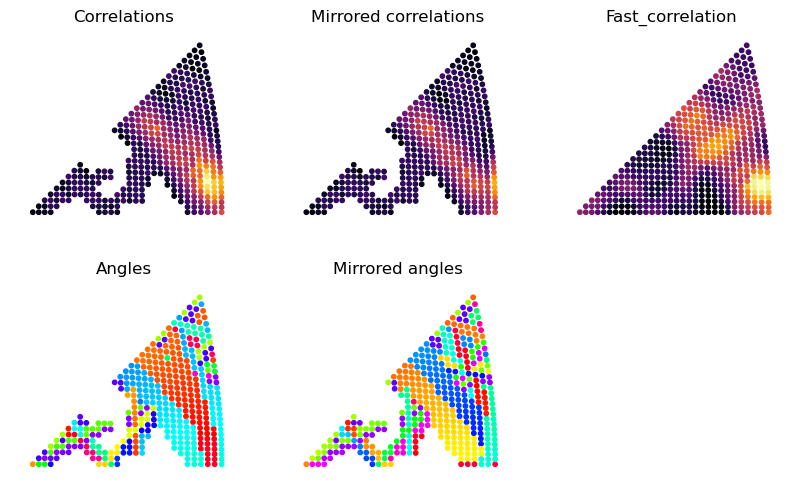

In [37]:
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (10, 6))

x, y = grid_to_xy(grid_cub)

ax = ax.ravel()
for i in ax:
    i.set_xlim(-0.05, 0.45)
    i.set_ylim(-0.05, 0.4)
    i.axis("off")
    i.set_aspect("equal")
    
s = 10

# to ensure the same color scale on mirror and non-mirror
all_cors = np.stack([corrs, corrs_m])
vmin = all_cors.min()
vmax = all_cors.max()

ax[0].scatter(x[indexes], y[indexes], s = s, c = corrs, cmap = "inferno", vmin = vmin, vmax = vmax)
ax[0].set_title("Correlations")
ax[1].scatter(x[indexes], y[indexes], s = s, c = corrs_m, cmap = "inferno", vmin = vmin, vmax = vmax)
ax[1].set_title("Mirrored correlations")
ax[2].scatter(x, y, s = s, c = fast_cors, cmap = "inferno")
ax[2].set_title("Fast_correlation")
ax[3].scatter(x[indexes], y[indexes], s = s, c = angles, cmap = "hsv")
ax[3].set_title("Angles")
ax[4].scatter(x[indexes], y[indexes], s = s, c = angles_m, cmap = "hsv")
ax[4].set_title("Mirrored angles")

In [38]:
plt.close()

It is easy to find the maximum of the returned correlations for each template to index the pattern, but there is also the shorthand function `get_n_best_matches` to find the `n` best matches ordered in descending order of correlation index.

In [39]:
# The number of best answers to return, not to be confused with n_keep!
n_best = 5
indices_n, angles_n, correlations_n, signs_n = iutls.get_n_best_matches(image,
                                                 simulations,
                                                 n_best,
                                                 frac_keep,
                                                 n_keep,
                                                 delta_r,
                                                 delta_theta,
                                                 max_r,
                                                 intensity_transform_function,
                                                 find_direct_beam,
                                                 direct_beam_position,
                                                 normalize_image,
                                                 normalize_templates,
                                                )

Returned are the indices of the best matching templates, the best fit in-plane angles, the best correlations, and the "signs" which refers to whether the normal pattern (1) or the mirrored pattern (-1) best fits the experiment.
In this case (see in the stereograms above) the mirrored templates are not as good of a match. Below we plot the best solutions on top of the correlation stereogram.

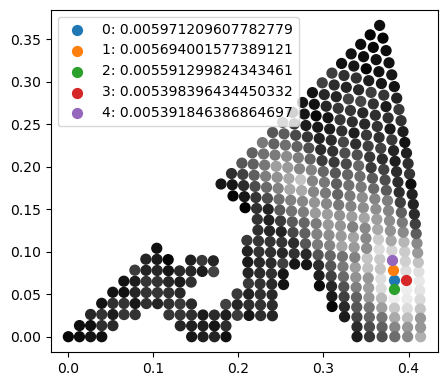

In [40]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.set_aspect("equal")
ax.scatter(x[indexes], y[indexes], s = 50, c = corrs, cmap = "Greys_r", vmin = vmin, vmax = vmax)
for j, i in enumerate(indices_n):
    ax.scatter(x[i], y[i], s = s*5, label = f"{j}: {correlations_n[j]}")
ax.legend()

In [41]:
plt.close()

We can also verify what the best matching pattern actually looks like as shown below

(<Axes: >,
 <matplotlib.collections.PathCollection at 0x16c6abe50>)

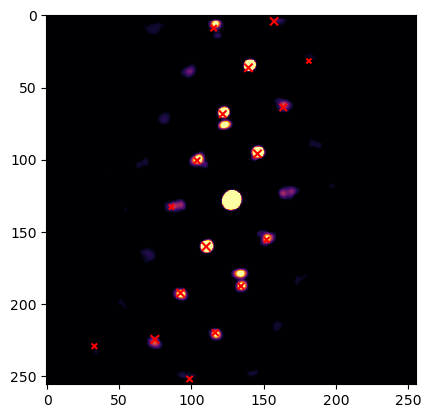

In [42]:
# signs will be 1 for the upper triangle, -1 for the lower triangle
mirrored = signs_n[0] == -1
putls.plot_template_over_pattern(image,
                                 simulations[indices_n[0]],
                                 in_plane_angle=angles_n[0],
                                 coordinate_system = "cartesian", 
                                 size_factor = 10,
                                 vmax=0.01, 
                                 max_r = 200,
                                 mirrored_template=mirrored,
                                 find_direct_beam=True,
                                 cmap = "inferno"
                                )

In [43]:
plt.close()

### <a id="mpmt"></a> Many patterns and many templates
This is when one wants to index an entire dataset. Since this can still take quite some time on large datasets, it is recommended to always check a few patterns individually first to see whether image processing, template simulation, and comparison parameters are adequately set.

In [44]:
# let's not throw away any templates prematurely and perform a full calculation on all
frac_keep = 1 

result, phasedict = iutls.index_dataset_with_template_rotation(experimental_data,
                                                    diff_lib_fe,
                                                    phases = ["fe"],  # if we have multiple phases we can also specify which ones we want to consider. If it's not specified, all phases are used.
                                                    n_best = n_best,
                                                    frac_keep = frac_keep,
                                                    n_keep = n_keep,
                                                    delta_r = delta_r,
                                                    delta_theta = delta_theta,
                                                    max_r = 115,
                                                    intensity_transform_function=intensity_transform_function,
                                                    normalize_images = normalize_image,
                                                    normalize_templates=normalize_templates,
                                                    )

[########################################] | 100% Completed | 5.94 sms


The structure of the result:
* **phase_index**: if there are multiple phases in the phase library, an integer representing which phase best fits. `phasedict` that is returned maps the integer to the string key that can be used to index into the original template library.
* **template_index**: which index in the template library of that phase fits best
* **orientation**: euler angles of the solution(s)
* **correlation**: correlation index of the solution(s)
* **mirrored_template**: wether the solution(s) template should be flipped over the x axis or not. Only relevant when you want to directly compare patterns to templates and you don't want to re-simulate the templates. It can also be valuable to check whether the solutions are consistently chosing one of the mirror options (e.g. a grain is fully `True`), or whether the solution is ambiguous (e.g. a grain fluctuates strongly between `True` and `False`).

All have shape `(scan_y, scan_x, n_best)` except orientations has shape `(scan_y, scan_x, n_best, 3)`. So to get the map of the best solution, index into the arrays with `[:,:,0, ...]`. The next best solution use `1` etc.

In [45]:
result.keys()

dict_keys(['phase_index', 'template_index', 'orientation', 'correlation', 'mirrored_template'])

In [46]:
result["phase_index"].shape

(26, 25, 5)

To visualize the data, we plot IPF's. Below is a somewhat ad-hoc solution; a more general solution for visualizing IPF's is under development in orix.

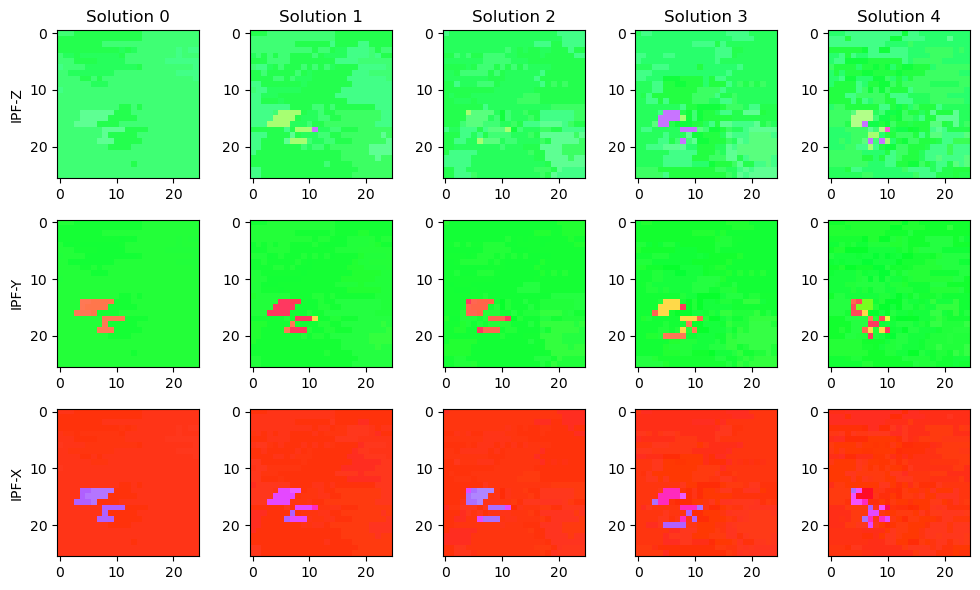

In [47]:
solution = result["orientation"]

import matplotlib.colors as mcolors
from orix.projections import StereographicProjection

# map a vector onto the fundamental zone of the cube
def to_fundamental(data_sol):
    data_sol = np.abs(data_sol)
    data_sol = np.sort(data_sol, axis=-1)
    column = data_sol[...,0].copy()
    data_sol[..., 0] = data_sol[...,1]
    data_sol[..., 1] = column
    return data_sol


def get_ipf_color(vectors):
    # the following column vectors should map onto R [100], G [010], B[001], i.e. the identity. So the inverse of 
    # this matrix maps the beam directions onto the right color vector
    color_corners = np.array([[0, 1, 1],
                              [0, 0, 1],
                              [1, 1, 1]])
    color_mapper = np.linalg.inv(color_corners)
    # a bit of wrangling
    data_sol = to_fundamental(vectors.data)
    flattened = data_sol.reshape(np.product(data_sol.shape[:-1]), 3).T
    rgb_mapped = np.dot(color_mapper, flattened)
    rgb_mapped = np.abs(rgb_mapped / rgb_mapped.max(axis=0)).T
    rgb_mapped = rgb_mapped.reshape(data_sol.shape)
    return rgb_mapped
    
    
from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d

# draw IPF - Z (row 1), IPF - Y (row 2), IPF - Z (row 3)
fig, ax = plt.subplots(ncols = solution.shape[2], nrows = 3, figsize = (10, 6))

for i in range(solution.shape[2]):
    solution_vectors_z = Rotation.from_euler(np.deg2rad(solution[:,:,i,:]))*Vector3d.zvector()    
    solution_vectors_y = Rotation.from_euler(np.deg2rad(solution[:,:,i,:]))*Vector3d.yvector()    
    solution_vectors_x = Rotation.from_euler(np.deg2rad(solution[:,:,i,:]))*Vector3d.xvector()    
    ax[0, i].set_title(f"Solution {i}")
    ax[0, i].imshow(get_ipf_color(solution_vectors_z))
    ax[1, i].imshow(get_ipf_color(solution_vectors_y))
    ax[2, i].imshow(get_ipf_color(solution_vectors_x))

ax[0,0].set_ylabel("IPF-Z")
ax[1,0].set_ylabel("IPF-Y")
ax[2,0].set_ylabel("IPF-X")

fig.tight_layout()

In [48]:
plt.close()

We can also now use the solution to check individual solutions

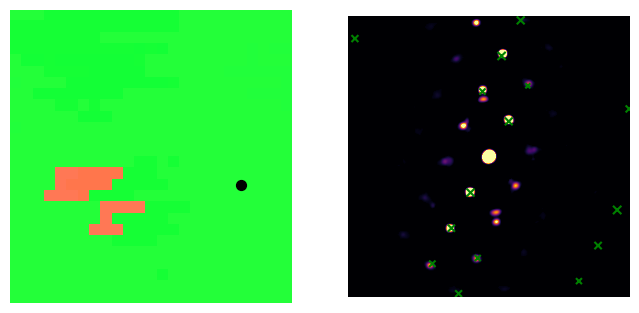

In [49]:
# scan coordinate to check
px = 20
py = 15
# which solution to plot
n_sol = 0

# query the necessary info from the solution
sim_sol_index = result["template_index"][py, px, n_sol]
mirrored_sol = result["mirrored_template"][py, px, n_sol]
in_plane_angle = result["orientation"][py, px, n_sol, 0] #! NOTE: the first angle is the in plane angle!
# query the appropriate template
sim_sol = simulations[sim_sol_index]

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

# calculating and plotting the IPF
solution_vectors_y = Rotation.from_euler(np.deg2rad(solution[:,:,n_sol,...]))*Vector3d.yvector()
ax[0].imshow(get_ipf_color(solution_vectors_y))
# plotting the point we chose
ax[0].scatter([px], [py], c="black", s=50)

# plotting the diffraction pattern and template
putls.plot_template_over_pattern(experimental_data.inav[px, py].data,
                                 sim_sol,
                                 ax=ax[1],
                                 in_plane_angle=in_plane_angle,
                                 coordinate_system = "cartesian", 
                                 size_factor = 10,
                                 vmax=0.02, 
                                 max_r = 200,
                                 mirrored_template=mirrored_sol,
                                 find_direct_beam=True,
                                 cmap = "inferno",
                                 marker_color = "green"
                                )
for i in ax:
    i.axis("off")

In [50]:
plt.close()

Some patterns may be incorrectly indexed. The template matching method can be sensitive to small modifications in the image processing parameters and simulation parameters. Consider extracting the individual images that give rise to problems and plot the correlation index stereographic triangles to figure out what is going wrong in those patterns and iterate.